In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import gym

In [3]:
env = gym.make("FrozenLake-v1")
n_obs = env.observation_space.n
n_acts = env.action_space.n
n_obs, n_acts

(16, 4)

In [5]:
#number of episode we will run
n_episodes = 10000

#maximum of iteration per episode
max_iter_episode = 100

#discounted factor
gamma = 0.99

#learning rate
lr = 0.1

In [39]:
class GreedQPolicy():
    
    def __init__(self, decay_rate=0.001, min_explore_prob=0.001):
        self.base_rate = 1.0
        self.decay_rate = decay_rate
        self.min_explore_prob = min_explore_prob
        
    def get_explore_rate(self, episode):
        return max(self.min_explore_prob, self.base_rate * np.exp(-self.decay_rate*episode))
    

In [44]:
def estimate_q(n_episodes, 
               max_iter_episode,
               lr = 0.1, 
               gamma = 0.99, 
               behavior_policy = GreedPolicy()):

    rewards = list()
    n_obs = env.observation_space.n
    n_acts = env.action_space.n
    Q_table = np.zeros((n_obs, n_acts))
    
    for e in range(n_episodes):
        #we initialize the first state of the episode
        current_state = env.reset()
        done = False

        #sum the rewards that the agent gets from the environment
        total_episode_reward = 0
        explore_rate = behavior_policy.get_explore_rate(e)

        for i in range(max_iter_episode): 
            # we sample a float from a uniform distribution over 0 and 1
            # if the sampled flaot is less than the exploration proba
            #     the agent selects arandom action
            # else
            #     he exploits his knowledge using the bellman equation 

            if np.random.uniform(0,1) < explore_rate:
                action = env.action_space.sample()
            else:
                action = np.argmax(Q_table[current_state,:])

            # The environment runs the chosen action and returns
            # the next state, a reward and true if the epiosed is ended.
            next_state, reward, done, _ = env.step(action)

            # We update our Q-table using the Q-learning iteration
            Q_table[current_state, action] = (1-lr) * Q_table[current_state, action] +lr*(reward + gamma*max(Q_table[next_state,:]))
            total_episode_reward = total_episode_reward + reward
            # If the episode is finished, we leave the for loop
            if done:
                break
            current_state = next_state
            
        rewards.append(total_episode_reward)
        
    return Q_table, rewards

In [55]:
def run_episode(env, Q_table, render=False):

    observation = env.reset()
    totalreward = 0

    observations = []
    actions = []
    rewards = []

    done = False

    while not done:
        if render:
            env.render()

        observations.append(observation)
        action = np.argmax(Q_table[observation,:])
        observation, reward, done, info = env.step(action)

        totalreward += reward
        rewards.append(reward)
        actions.append(action)

    return totalreward, np.array(rewards),  \
            np.array(observations), np.array(actions)

In [45]:
Q_table, rewards = estimate_q(n_episodes, max_iter_episode, lr, gamma)

In [42]:
sz = 50
step = len(rewards)//sz
mean_rewards = [np.mean(rewards[step*i:step*(i+1)]) for i in range(sz)]

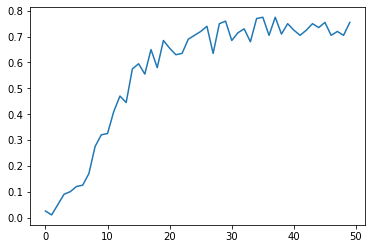

In [43]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.plot(mean_rewards);

In [57]:
_ = run_episode(env, Q_table, render=True)

(1.0,
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 1.]),
 array([ 0,  4,  0,  0,  0,  0,  4,  4,  4,  0,  0,  4,  0,  0,  0,  0,  4,
         8,  9, 10,  9,  8,  4,  4,  8,  8,  8,  8,  9, 13,  9,  8,  9, 13,
        14, 14]),
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 1, 0, 1, 3,
        0, 0, 3, 3, 3, 3, 1, 2, 1, 3, 1, 2, 1, 1], dtype=int64))

In [58]:
env.close()